In [1]:
from matplotlib import pyplot as plt 
import numpy as np 
from skimage import morphology
from skimage import segmentation
from joblib import Parallel, delayed
import multiprocessing
import skimage

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

In [5]:
def create_mask(im, segments, disk_size, slic_sigma, slic_compactness,cut_off): 
    im_col = plt.imread(im)
    dim_one, dim_two = (len(im_col),len(im_col[0]))
    
    im_gray = rgb2gray(im_col)
    thres = skimage.filters.threshold_otsu(im_gray)
    mask = im_gray < thres
    struct_el = morphology.disk(disk_size)

    opened = morphology.closing(mask,struct_el)
    tmp_mask = skimage.segmentation.clear_border(opened)
    tmp_label = skimage.measure.label(tmp_mask)
    tmp_label = tmp_label * tmp_mask

    
    col_mask = im_gray * tmp_label 
    tmp = segmentation.slic(col_mask, n_segments = segments, sigma = slic_sigma, compactness = slic_compactness, start_label = 1)
    tmp_list = []
    tmp_dict = {}
    for i in range(1,segments+1): 
        tmp_index = np.argwhere(tmp == i)
        # tmp_array = np.where(tmp == i)
        tmp_index = [(k[0],k[1]) for k in tmp_index]
        tmp_dict[str(i)] = {"Coordinates": tmp_index,
                    "Values": [mask[k[0],k[1]] for k in tmp_index],
                    "Sum": 0,
                    "Result": 0}
        tmp_dict[str(i)]['Sum'] = sum(tmp_dict[str(i)]['Values'])
        if tmp_dict[str(i)]["Sum"] > len(tmp_dict[str(i)]["Values"])*cut_off:
            tmp_dict[str(i)]["Result"] = 1
    tmp_tmp_list = []
    for i in tmp_dict: 
        if tmp_dict[i]['Result'] == 1: 
            # print(i)
            tmp_tmp_list.append(int(i))

    tmp_array = np.zeros((dim_one,dim_two))
    for i in tmp_tmp_list: 
        for k in tmp_dict[str(i)]['Coordinates']: 
            tmp_array[k[0],k[1]] = 1
    
    return tmp_array 


In [6]:
im = create_mask("../data/example_image/ISIC_0001852.jpg",250,5,1,10,0.6)

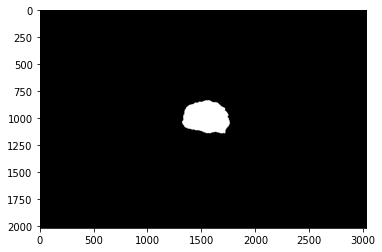

In [7]:
plt.imshow(im,cmap="gray")